# Imports

In [2]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
import altair as alt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import ensemble
from sklearn import impute
from sklearn import compose
from sklearn import metrics
from sklearn import inspection

import lightgbm as lgb
import catboost as cgb

pd.set_option('display.max_rows',    1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width',       1000)
alt.data_transformers.disable_max_rows()
sb.set()


# Read data

In [3]:
train = pd.read_csv("data/train_featEng.csv",    index_col="Id")
test  = pd.read_csv("data/test_featEng.csv",     index_col="Id")
sub   = pd.read_csv("data/sampleSubmission.csv", index_col="Id")
print(len(train), len(test), len(sub))
train.head()

160435 68758 68758


,Marca,Modelo,Tiempo,Provincia,Localidad,Ano,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio,Latitude,Longitude,Motor_litros,Modelo_1st,Modelo_padre,Tiempo_dias,Tiempo_tipo
Id,,,,,,,,,,,,,,,,,,,,
0,OPEL,VECTRA,33 días,la_rioja,Arnedo,2005.0,200000.0,manual,120.0,diesel,5.0,Profesional,2200,42.328553,-2.467492,NaN,VECTRA,VECTRA,33.000000,dias
1,NISSAN,PRIMERA,43 horas,aragon,Teruel,2008.0,400000.0,manual,100.0,diesel,4.0,Particular,3500,41.378729,-0.763937,NaN,PRIMERA,PRIMERA,1.791667,horas
2,RENAULT,CLIO BUSINESS DCI 75 ECO2,14 horas,sevilla,Camas,2014.0,53565.0,manual,75.0,diesel,5.0,Profesional,8200,37.388630,-5.995340,NaN,CLIO,CLIO,0.583333,horas
3,MERCEDES-BENZ,CLASE_CLS,1 hora,burgos,Burgos,2007.0,215000.0,automat,224.0,diesel,4.0,Particular,12500,42.343926,-3.696977,NaN,CLASE_CLS,CLASE_C,0.041667,hora
4,RENAULT,CAPTUR LIFE ENERGY DCI 90 ECO2 EURO 6,45 días,caceres,Caceres,2016.0,119945.0,manual,90.0,diesel,5.0,Profesional,9900,39.474517,-6.371676,NaN,CAPTUR,CAPTUR,45.000000,dias


---
# <center> TRAIN: 80% VAL: 20%
---

# Validation Strategy

In [4]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train,
                                                                      train.Precio,
                                                                      test_size=0.2,
                                                                      random_state=0)

# Select Features

In [5]:
# "Modelo", 
tex_vars = ["Modelo"]
cat_vars = ["Marca", "Modelo_padre", "Modelo_1st", "Cambio", "Combust", "Vendedor", "Tiempo_tipo"]#"Provincia" "Localidad"
num_vars = ["Ano", "Kms", "Cv", "Tiempo_dias", "Latitude", "Longitude", "Motor_litros"] # 
ord_vars = ["Puertas"]
target_var = "Precio"

x_train_featSel = x_train[cat_vars + ord_vars + num_vars]
x_valid_featSel = x_valid[cat_vars + ord_vars + num_vars]
x_test_featSel  = test[cat_vars + ord_vars + num_vars]

# Preprocessing

In [6]:
# Logs ???
num_preprocessing = pipeline.Pipeline(steps=[
    ('imputer',   impute.SimpleImputer(strategy='median', add_indicator=True)),
    #('encoder',   preprocessing.StandardScaler())
])

cat_preprocessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', preprocessing.OrdinalEncoder())
    #('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

ord_preprocessing = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-1))
])

preprocessor = compose.ColumnTransformer(transformers=[
    ('cat', cat_preprocessing, cat_vars),
    ('ord', ord_preprocessing, ord_vars),
    ('num', num_preprocessing, num_vars)
])

preprocessor.fit(pd.concat([x_train_featSel,
                            x_valid_featSel,
                            x_test_featSel]))

feat_names = cat_vars + ord_vars + ["Ano", "Kms", "Cv", "Tiempo_dias", "Latitude", "Longitude", "Motor_litros",
              "Ano_missing", "Kms_missing", "Cv_missing", "Motor_litros_mis"]

x_train_prep = pd.DataFrame(data=preprocessor.transform(x_train_featSel), columns=feat_names)
x_valid_prep = pd.DataFrame(data=preprocessor.transform(x_valid_featSel), columns=feat_names)
x_test_prep  = pd.DataFrame(data=preprocessor.transform(x_test_featSel),  columns=feat_names)

In [7]:
x_train.head(6)

,Marca,Modelo,Tiempo,Provincia,Localidad,Ano,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio,Latitude,Longitude,Motor_litros,Modelo_1st,Modelo_padre,Tiempo_dias,Tiempo_tipo
Id,,,,,,,,,,,,,,,,,,,,
108185,JAGUAR,X TIPE 2. 2DIESEL,4 días,la_coruna,Arteixo,2008.0,190000.0,manual,150.0,diesel,4.0,Profesional,6500,43.371209,-8.395877,2.2,X,ES,4.000000,dias
77939,VOLKSWAGEN,SCIROCCO 1. 4 TSI 160CV,3 días,aragon,Zaragoza,2011.0,65313.0,manual,160.0,gasolina,3.0,Profesional,14500,41.378729,-0.763937,1.4,SCIROCCO,SCIROCCO,3.000000,dias
122901,TOYOTA,YARIS,5 horas,cordoba,Córdoba,2008.0,150000.0,manual,87.0,gasolina,5.0,Particular,3199,37.884581,-4.776014,NaN,YARIS,YARIS,0.208333,horas
21949,AUDI,A5 SPORTBACK 2. 0 TDI 170CV,39 días,castellon,Vinaros,2011.0,236000.0,manual,170.0,diesel,5.0,Profesional,11890,40.251857,-0.061505,2.0,A5,A5,39.000000,dias
154506,RENAULT,MEGANE BUSINESS ENERGY DCI 110 SS,7 días,huesca,Huesca,2012.0,67000.0,automat,110.0,diesel,5.0,Profesional,10500,42.136061,-0.029803,NaN,MEGANE,MEGANE,7.000000,dias
31935,BMW,318,7 horas,castellon,Burriana,2009.0,165000.0,manual,143.0,diesel,5.0,Profesional,5950,40.251857,-0.061505,NaN,318,318,0.291667,horas


In [8]:
x_train_prep.head(6)

,Marca,Modelo_padre,Modelo_1st,Cambio,Combust,Vendedor,Tiempo_tipo,Puertas,Ano,Kms,Cv,Tiempo_dias,Latitude,Longitude,Motor_litros,Ano_missing,Kms_missing,Cv_missing,Motor_litros_mis
0,29.0,214.0,4161.0,1.0,1.0,1.0,1.0,4.0,2008.0,190000.0,150.0,4.000000,43.371209,-8.395877,2.2,0.0,0.0,0.0,0.0
1,66.0,438.0,3481.0,1.0,3.0,1.0,1.0,3.0,2011.0,65313.0,160.0,3.000000,41.378729,-0.763937,1.4,0.0,0.0,0.0,0.0
2,65.0,575.0,4276.0,1.0,3.0,0.0,3.0,5.0,2008.0,150000.0,87.0,0.208333,37.884581,-4.776014,1.6,0.0,0.0,0.0,1.0
3,4.0,77.0,836.0,1.0,1.0,1.0,1.0,5.0,2011.0,236000.0,170.0,39.000000,40.251857,-0.061505,2.0,0.0,0.0,0.0,0.0
4,51.0,323.0,2760.0,0.0,1.0,1.0,1.0,5.0,2012.0,67000.0,110.0,7.000000,42.136061,-0.029803,1.6,0.0,0.0,0.0,1.0
5,7.0,38.0,365.0,1.0,1.0,1.0,3.0,5.0,2009.0,165000.0,143.0,0.291667,40.251857,-0.061505,1.6,0.0,0.0,0.0,1.0


# Model

In [9]:
model = ensemble.RandomForestRegressor(
          n_estimators=100,
          random_state=0,
          n_jobs=-1)

In [10]:
model = lgb.LGBMRegressor()

In [28]:
model = cgb.CatBoostRegressor()

In [11]:
model.fit(x_train_prep, np.log1p(y_train), verbose=False);

# Evaluate

In [12]:
preds = np.expm1(model.predict(x_valid_prep))
#probs = model.predict_proba(x_valid)

In [13]:
def evalRounds(preds, real):
    preds_1    = np.round(preds, decimals=0)
    preds_10   = np.round(preds, decimals=-1)
    preds_100  = np.round(preds, decimals=-2)
    preds_1000 = np.round(preds, decimals=-3)
    
    error_float  = np.sqrt(metrics.mean_squared_log_error(real, preds))
    errors_int   = np.sqrt(metrics.mean_squared_log_error(real, preds_1))
    errors_10s   = np.sqrt(metrics.mean_squared_log_error(real, preds_10))
    errors_100s  = np.sqrt(metrics.mean_squared_log_error(real, preds_100))
    errors_1000s = np.sqrt(metrics.mean_squared_log_error(real, preds_1000))
    
    return [error_float, errors_int, errors_10s, errors_100s, errors_1000s]

evalRounds(preds, y_valid)

[0.37212057290393785,
 0.37212143200831516,
 0.3721117469600652,
 0.37222890178984785,
 0.38247462130374643]

### QQ plot

In [21]:
val                        = x_valid.copy()
val['Precio real']         = y_valid
val['Precio predicho']     = preds
val['Log precio real']     = np.log(y_valid)
val['Log precio predicho'] = np.log(preds)
val['Log abs error']       = abs(val['Log precio real'] - val['Log precio predicho'])

In [22]:
val['Log abs error']

Id
94028     0.954234
125916    0.400650
15660     0.135790
37348     1.126621
90664     0.188954
            ...   
125620    0.031850
76430     0.250000
54350     0.049379
63407     0.118135
93675     0.044705
Name: Log abs error, Length: 32087, dtype: float64

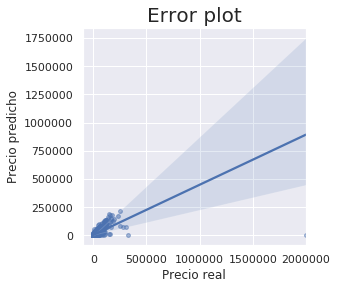

In [32]:
plt.figure(figsize=(4,4))
sb.regplot(x=val['Precio real'],
           y=val['Precio predicho'],
           order=1,
           scatter_kws={'alpha':0.5, "s": 15}).set_title("Error plot", fontsize=20);

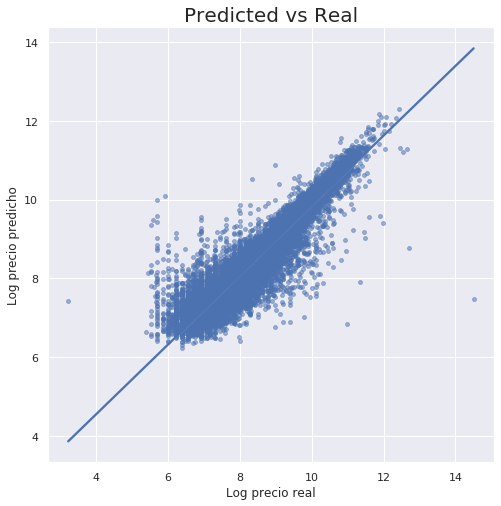

In [33]:
plt.figure(figsize=(8,8))
sb.regplot(x=val['Log precio real'],
           y=val['Log precio predicho'],
           order=1,
           scatter_kws={'alpha':0.5, "s": 15}).set_title("Predicted vs Real", fontsize=20);

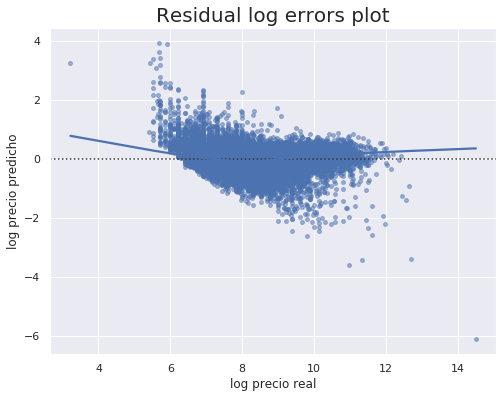

In [18]:
plt.figure(figsize=(8, 6))
sb.residplot(x=val['Log precio real'],
             y=val['Log precio predicho'],
             lowess=True,
             scatter_kws={'alpha':0.5, "s": 15}).set_title("Residual log errors plot", fontsize=20);

In [34]:
len(val)

32087

In [95]:
top1000errors.columns

Index(['Marca', 'Modelo', 'Tiempo', 'Provincia', 'Localidad', 'Ano', 'Kms', 'Cambio', 'Cv', 'Combust', 'Puertas', 'Vendedor', 'Precio', 'Latitude', 'Longitude', 'Motor_litros', 'Modelo_1st', 'Modelo_padre', 'Tiempo_dias', 'Tiempo_tipo', 'Precio real', 'Precio predicho', 'Log precio real', 'Log precio predicho', 'Log abs error'], dtype='object')

In [103]:
top1000errors = val.nlargest(1000, 'Log abs error')
top1000errors[['Marca', 'Modelo', 'Ano', 'Kms', 'Tiempo', 'Cv', 'Combust',
               'Vendedor', 'Precio real', 'Precio predicho', 'Log abs error']].head(30)

,Marca,Modelo,Ano,Kms,Tiempo,Cv,Combust,Vendedor,Precio real,Precio predicho,Log abs error
Id,,,,,,,,,,,
134563,AUDI,BMW X99999,NaN,NaN,38 días,NaN,gasolina,Profesional,2000000,2090.393516,6.863550
110743,AUDI,Q7,2008.0,100000.0,2 días,326.0,diesel,Particular,295,22737.519537,4.344796
141541,SEAT,LEON,2019.0,11000.0,45 min,150.0,diesel,Particular,366,26211.324579,4.271313
41222,ALFA ROMEO,SEAT,2018.0,22.0,44 días,NaN,gasolina,Particular,295,16666.200570,4.034163
124260,RENAULT,4L,NaN,NaN,nuevo anuncio,NaN,gasolina,Particular,25,1372.058778,4.005192
142047,AUDI,A3,2013.0,328000.0,43 días,105.0,diesel,Particular,328000,6643.017619,3.899447
30681,RENAULT,MILDIUM,NaN,392000.0,15 días,NaN,diesel,Profesional,58500,1201.805056,3.885202
125568,FORD,TAUNUS 15M,1952.0,NaN,39 horas,NaN,gasolina,Particular,300,13964.987341,3.840526
7994,VOLKSWAGEN,SCIROCCO,2010.0,55000.0,4 días,160.0,gasolina,Particular,250,11556.287229,3.833524


In [94]:
alt.Chart(top1000errors).mark_circle(size=30).encode(
    x=alt.X('Precio real:Q',     scale=alt.Scale(type='log')),
    y=alt.Y('Precio predicho:Q', scale=alt.Scale(type='log')),
    color=alt.Color("Log abs error", scale=alt.Scale(scheme='blues', type='log')),
    #color="Tiempo_dias",
    size="Log abs error",
    tooltip=['Marca', 'Modelo', "Ano", "Kms", "Provincia", 'Precio real', 'Precio predicho']
).properties(
    width=600,
    height=300
).interactive()

#df   = pd.DataFrame({'x': [0,10000], 'y': [0,10000]})
#iden = alt.Chart(df).mark_line().encode(x='x',y='y')
#iden.transform_regression('Precio real', 'Precio predicho').mark_line()
#chart + iden.mark_line()
#iden + chart
#alt.layer(chart, iden)

alt.Chart(...)

---
# <center> REPEATED STRATIFIED CROSS VALIDATION
---

In [107]:
#folds = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
folds = model_selection.RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
#folds = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

errors_float = []
errors_int   = []
errors_10s   = []
errors_100s  = []
errors_1000s = []
for trn_idx, val_idx in folds.split(x_train_prep, y_train):
    
    x_trn, y_trn = x_prep.iloc[trn_idx], y[trn_idx]
    x_val, y_val = x_prep.iloc[val_idx], y[val_idx]
    
    model = lgb.LGBMRegressor()
    #model = cgb.CatBoostRegressor()
    model.fit(x_trn, np.log1p(y_trn), verbose=False)
    
    preds = np.expm1(model.predict(x_val))
    
    e, e1, e10, e100, e1000 = evalRounds(preds, y_val)
    errors_float.append(e)
    errors_int.append(e1)
    errors_10s.append(e10)
    errors_100s.append(e100)
    errors_1000s.append(e1000)
    print(e)

errors_float = np.array(errors_float)
errors_int   = np.array(errors_int)
errors_10s   = np.array(errors_10s)
errors_100s  = np.array(errors_100s)
errors_1000s = np.array(errors_1000s)
print("Error float:", errors_float.mean(), "+-", errors_float.std())
print("Error int:  ", errors_int.mean(), "+-", errors_int.std())
print("Error 10s:  ", errors_10s.mean(), "+-", errors_10s.std())
print("Error 100s: ", errors_100s.mean(), "+-", errors_100s.std())
print("Error 1000s:", errors_1000s.mean(), "+-", errors_1000s.std())

NameError: name 'x_prep' is not defined

---
# <center> TRAIN WITH ALL DATA
---

In [15]:
model = lgb.LGBMRegressor()
model = cgb.CatBoostRegressor()
model.fit(x_prep, np.log1p(y), verbose=False)

preds = np.expm1(model.predict(t_prep))
preds

array([9013.60347307, 3050.36220569, 4019.24981445, ..., 2664.9966318 ,
        837.63344912, 8838.82786923])

In [16]:
len(preds), len(test), len(sub)

(68758, 68758, 68758)

In [17]:
sub['Precio'] = preds # test_preds.astype(int)
sub.head()

,Precio
Id,
0,9013.603473
1,3050.362206
2,4019.249814
3,2491.200846
4,2060.284606


In [18]:
sub.to_csv('sub2_cat.csv')

In [20]:
!head sub2_cat.csv

Id,Precio
0,9013.603473073945
1,3050.362205687619
2,4019.249814450347
3,2491.200845559345
4,2060.284605855906
5,1506.492501980553
6,10440.199617452352
7,867.0595344699301
8,4129.80673462706


# Inspection

In [11]:
model.feature_importances_

array([585, 242, 306,  60,  81,  25,   6, 101, 486, 256, 461,  34,  67,
        64,  59,  60,  34,  62,  11], dtype=int32)

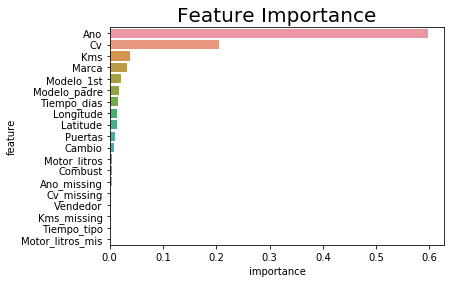

In [20]:
fi = pd.DataFrame({
      'feature':     feat_names, #x.columns,
      'importance':  model.feature_importances_
     }).sort_values('importance', ascending=False).reset_index(drop=True)

# Plot
sb.barplot(x=fi.importance, y=fi.feature).set_title("Feature Importance",  fontsize=20);

In [21]:
# Compute Permutation Feature Importance
pfi = inspection.permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=0, n_jobs=1)

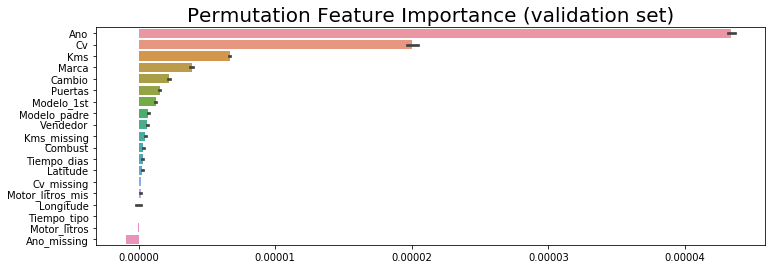

In [22]:
# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data   =pfi.importances[sorted_idx].T,
                      columns=np.array(feat_names)[sorted_idx]) #x_valid.columns[sorted_idx])

# Plot (This can be barplot, boxplot, violinplot,...)
plt.figure(figsize=(12,4))
sb.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance (validation set)",  fontsize=20);

In [32]:
#fig, ax = plt.subplots(figsize=(16, 4))
#inspection.plot_partial_dependence(
#    estimator=model,
#    X=train_prepro,
#    features=["Año", "Kms", "Cv", "Puertas"],
#    grid_resolution=100,
#    n_cols=4,
#    ax=ax,
#    n_jobs=-1
#   );